# Lab5 - Image Segmentation
## Abeer Ahmad (38) - Mohammed Deifallah (59)

## Imports

**We have 4 main modules:**
1. **data_util:** sets dataset image files.
2. **image_util:** visualizes dataset samples, both images as well as ground truth segmentations.
3. **kmeans:** implements the *K-means* algorithm given number of clusters (k) and an optional number of iterations (default 5), returning the image labels (clusters) and the new segmented image.
4. **normalized_cut:** performs the *Normalized Cut* algorithm given combinantion of different parameters, returning the image labels (clusters).

In [1]:
import os
from os import listdir
from os.path import isfile, join

from scipy.io import loadmat

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score

import cv2

import numpy as np
import pandas as pd
import random

import image_util as im
import data_util as dt
import normalized_cut as nc
import kmeans

%load_ext autoreload
%autoreload 2

## Dataset

*It's mentioned in the dataset documentation, besides the problem statement, that the dataset contains $500$ images as its name shows. These images have $300$ as a training set, while the remaining $200$ ones are the testing set.*
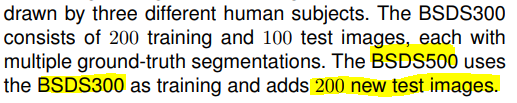

In [2]:
ROOT = '../../BSR/BSDS500/data/'

In [3]:
train_images, ground_truth_train_images, val_images, ground_truth_val_images, test_images, ground_truth_test_images = dt.get_data(ROOT)

#Assert that each two corresponding directories has the same number of files
print("The total number of training images:")
print("\t-images:{}, ground truth segmentation:{}".format(len(train_images), len(ground_truth_train_images)))
num_train = len(train_images)

print("The total number of validation images:")
print("\t-images:{}, ground truth segmentation:{}".format(len(val_images), len(ground_truth_val_images)))
num_val = len(val_images)

print("The total number of testing images:")
print("\t-images:{}, ground truth segmentation:{}".format(len(test_images), len(ground_truth_test_images)))
num_test = len(test_images)

The total number of training images:
	-images:200, ground truth segmentation:200
The total number of validation images:
	-images:100, ground truth segmentation:100
The total number of testing images:
	-images:200, ground truth segmentation:200


## Image Visualization

### Understand the Format

In [15]:
mat = loadmat(ground_truth_train_images[0])

print(type(mat.get('groundTruth')))
print(mat.get('groundTruth').shape)
print(mat.get('groundTruth').size)
print('=============================')
print(type(mat.get('groundTruth')[0][0]))
print(mat.get('groundTruth')[0][0].shape)
print('=============================')
print(type(mat.get('groundTruth')[0][0]['Segmentation']))
print(mat.get('groundTruth')[0][0]['Segmentation'].shape)
print(mat.get('groundTruth')[0][0]['Segmentation'].tolist())
print('-----------------------------')
print(type(mat.get('groundTruth')[0][0]['Segmentation'][0][0]))
print(mat.get('groundTruth')[0][0]['Segmentation'][0][0].shape)
print(mat.get('groundTruth')[0][0]['Segmentation'][0][0].tolist())

<class 'numpy.ndarray'>
(1, 6)
6
<class 'numpy.ndarray'>
(1, 1)
<class 'numpy.ndarray'>
(1, 1)
[[array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ..., 
       [11, 11, 11, ..., 14, 14, 14],
       [11, 11, 11, ..., 14, 14, 14],
       [11, 11, 11, ..., 14, 14, 14]], dtype=uint16)]]
-----------------------------
<class 'numpy.ndarray'>
(321, 481)
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Read and Display Images

**We display 3 samples from our training set, each along with one of multiple corresponding ground truth segmentations.**

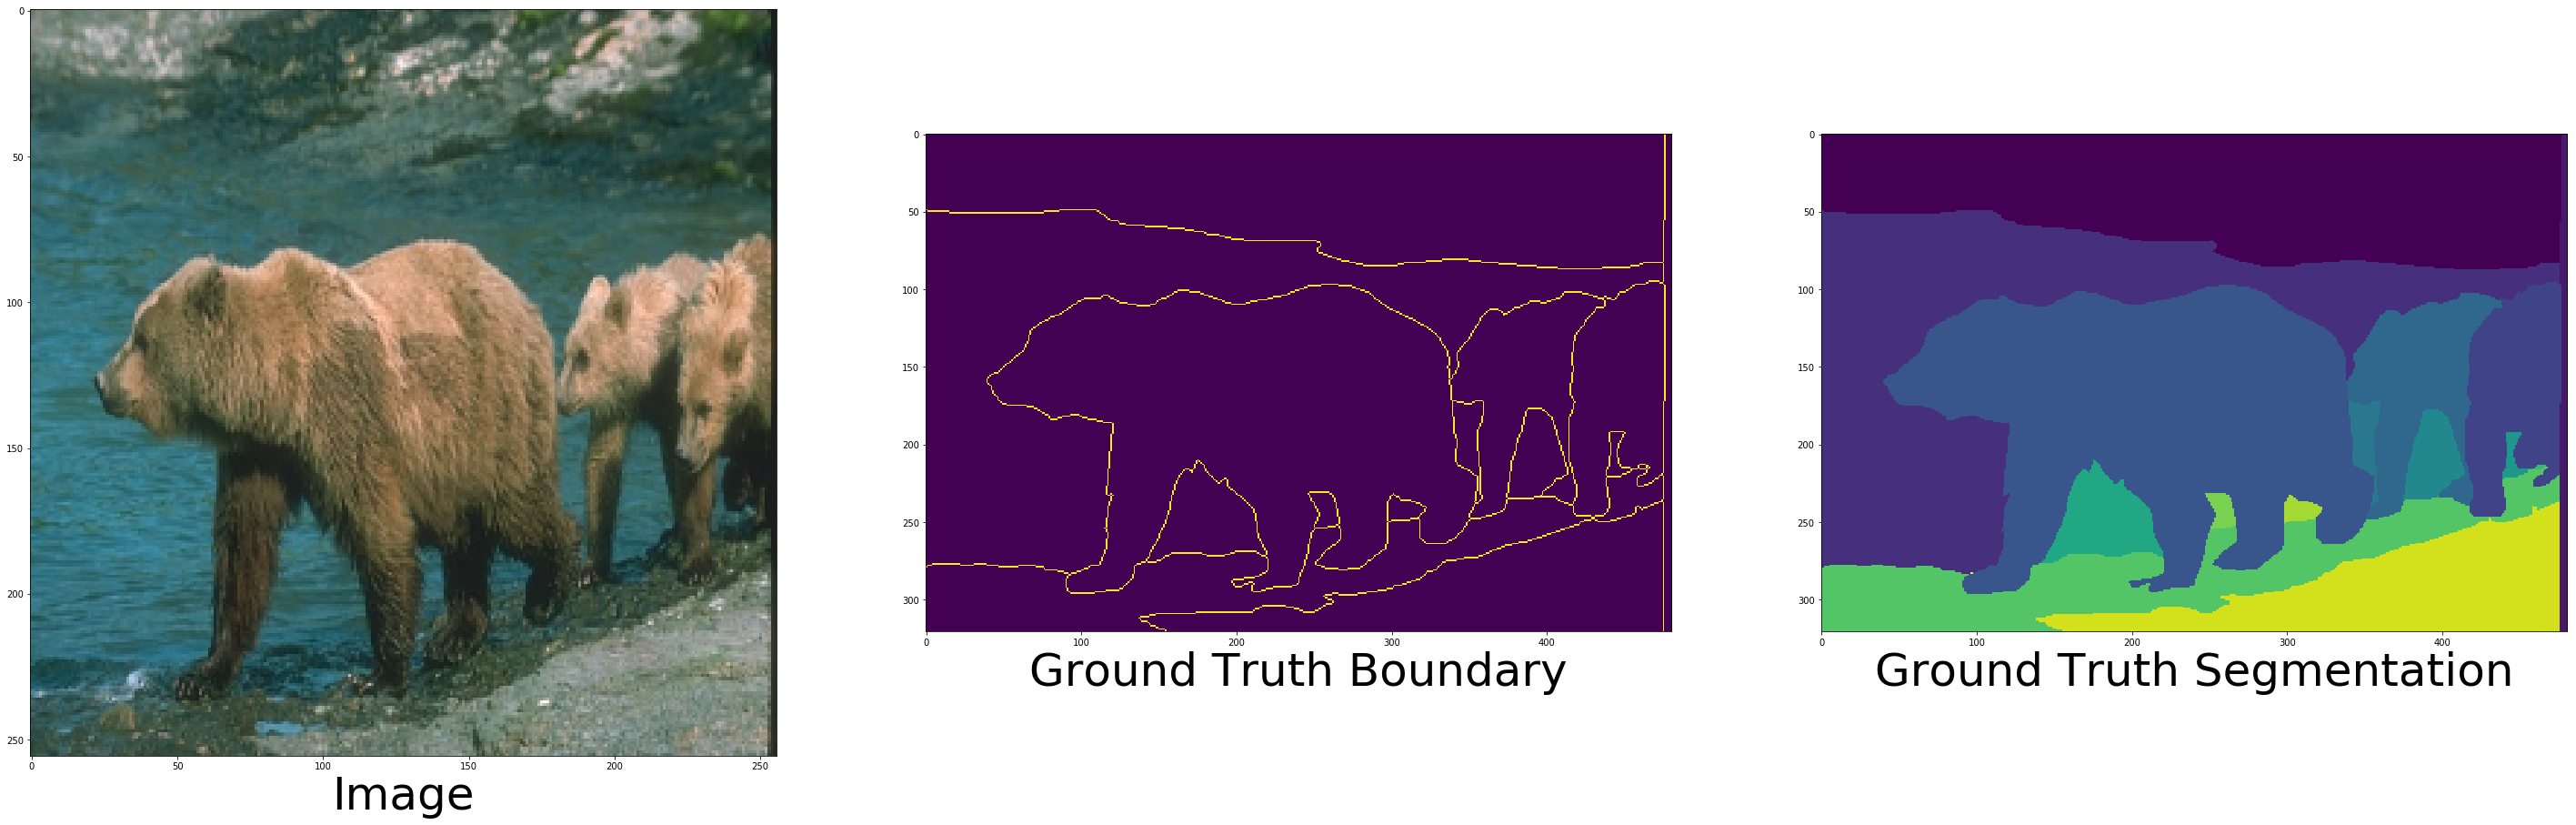

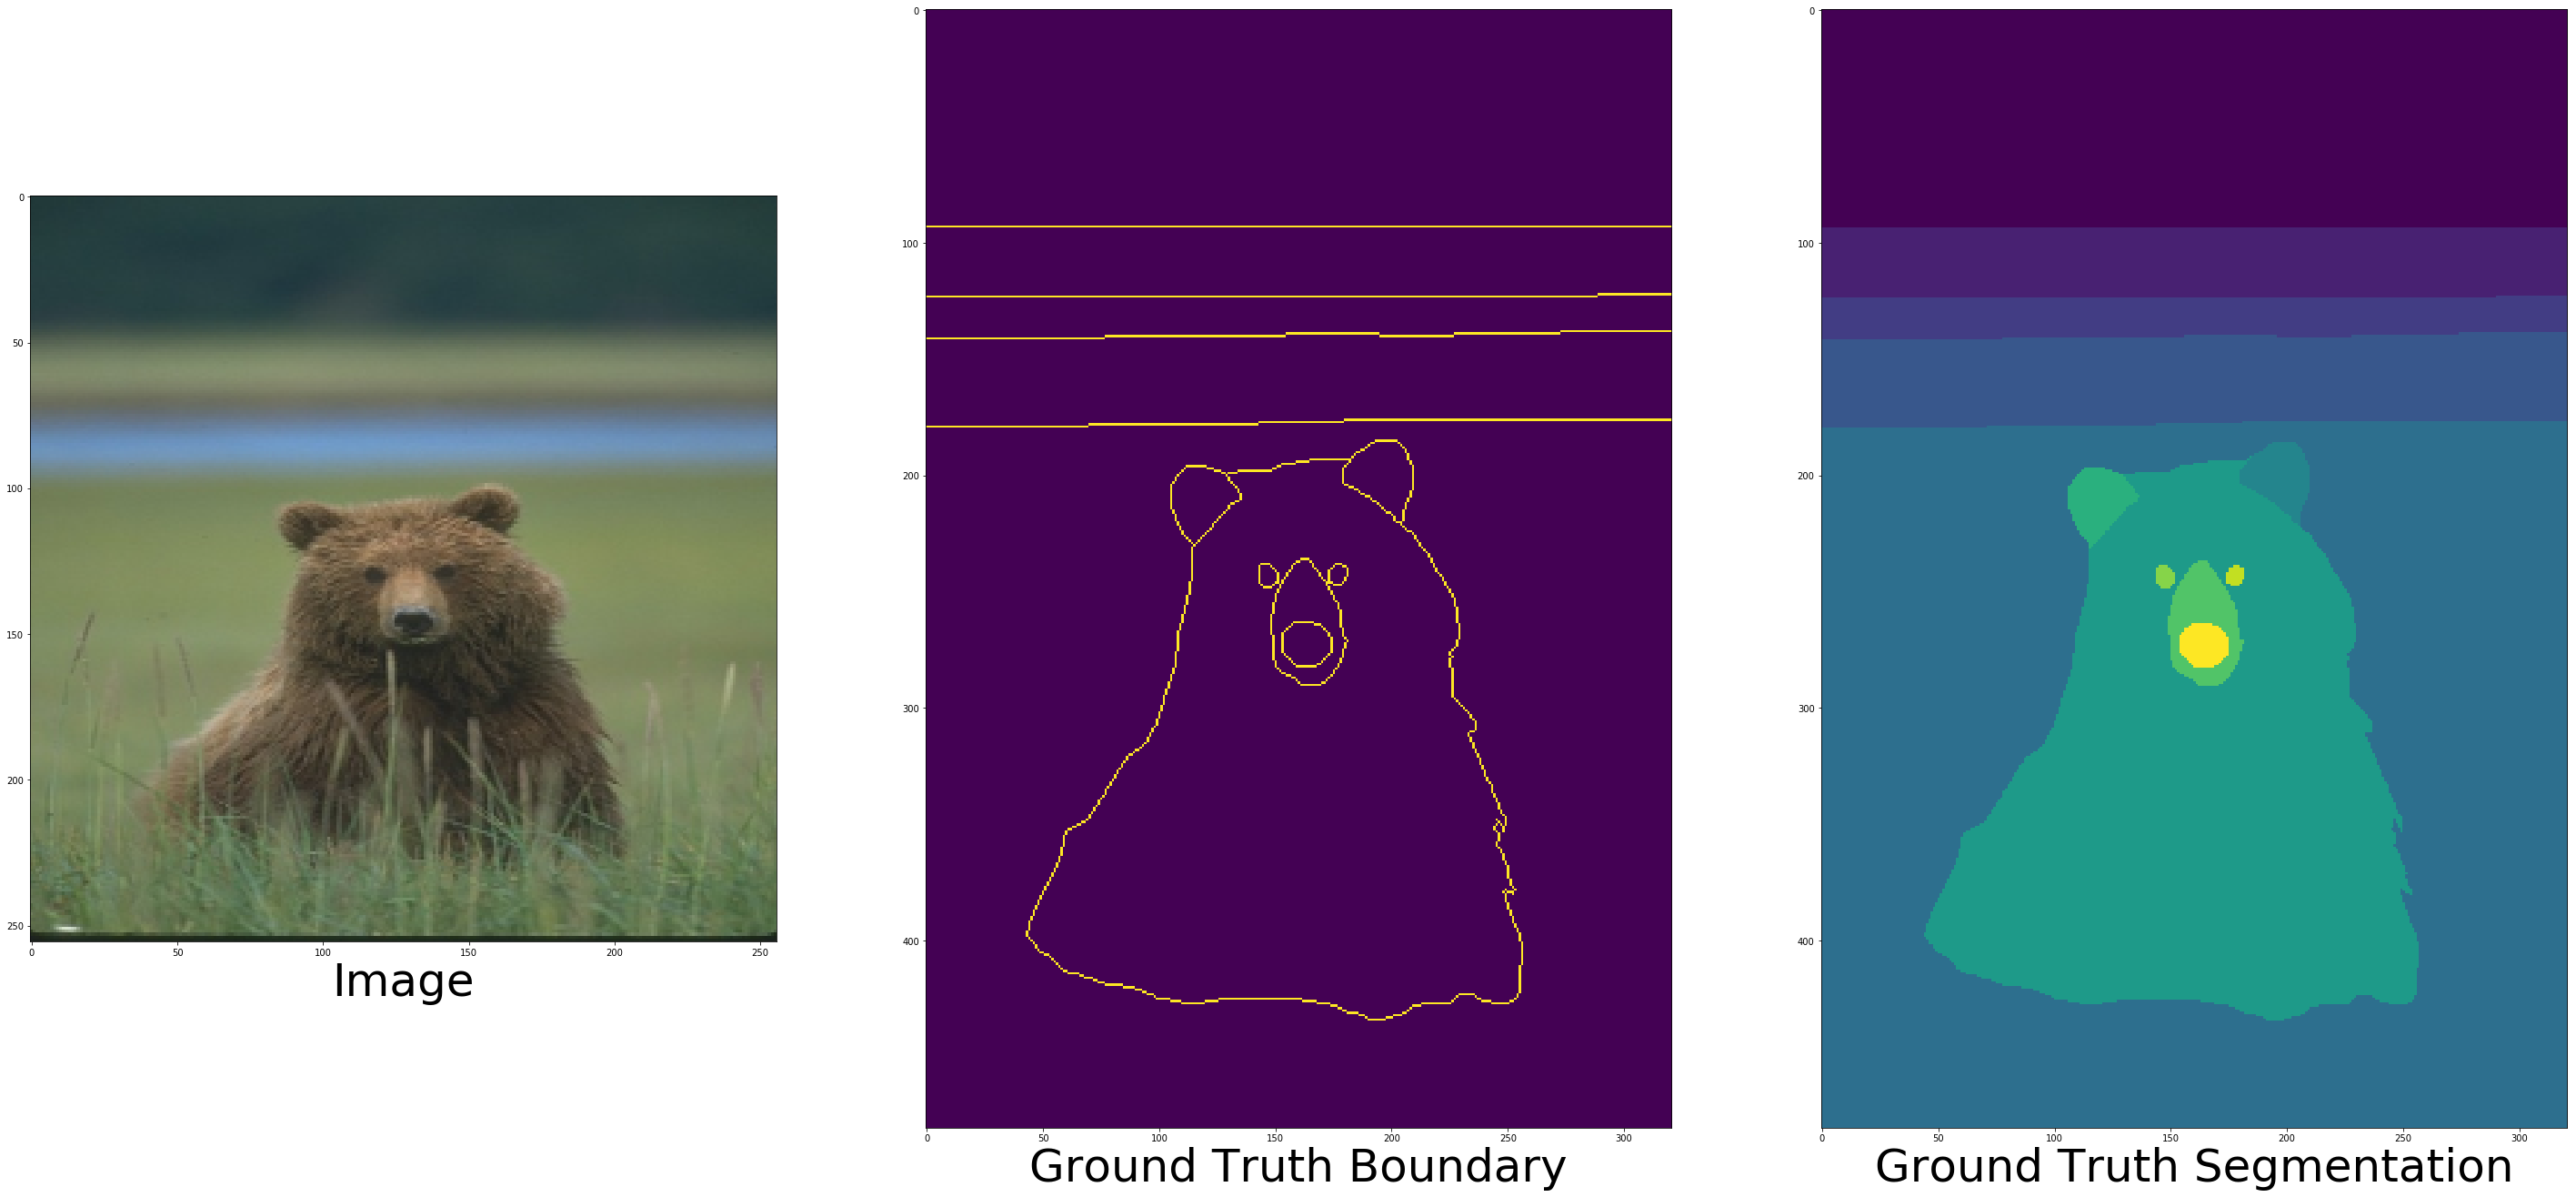

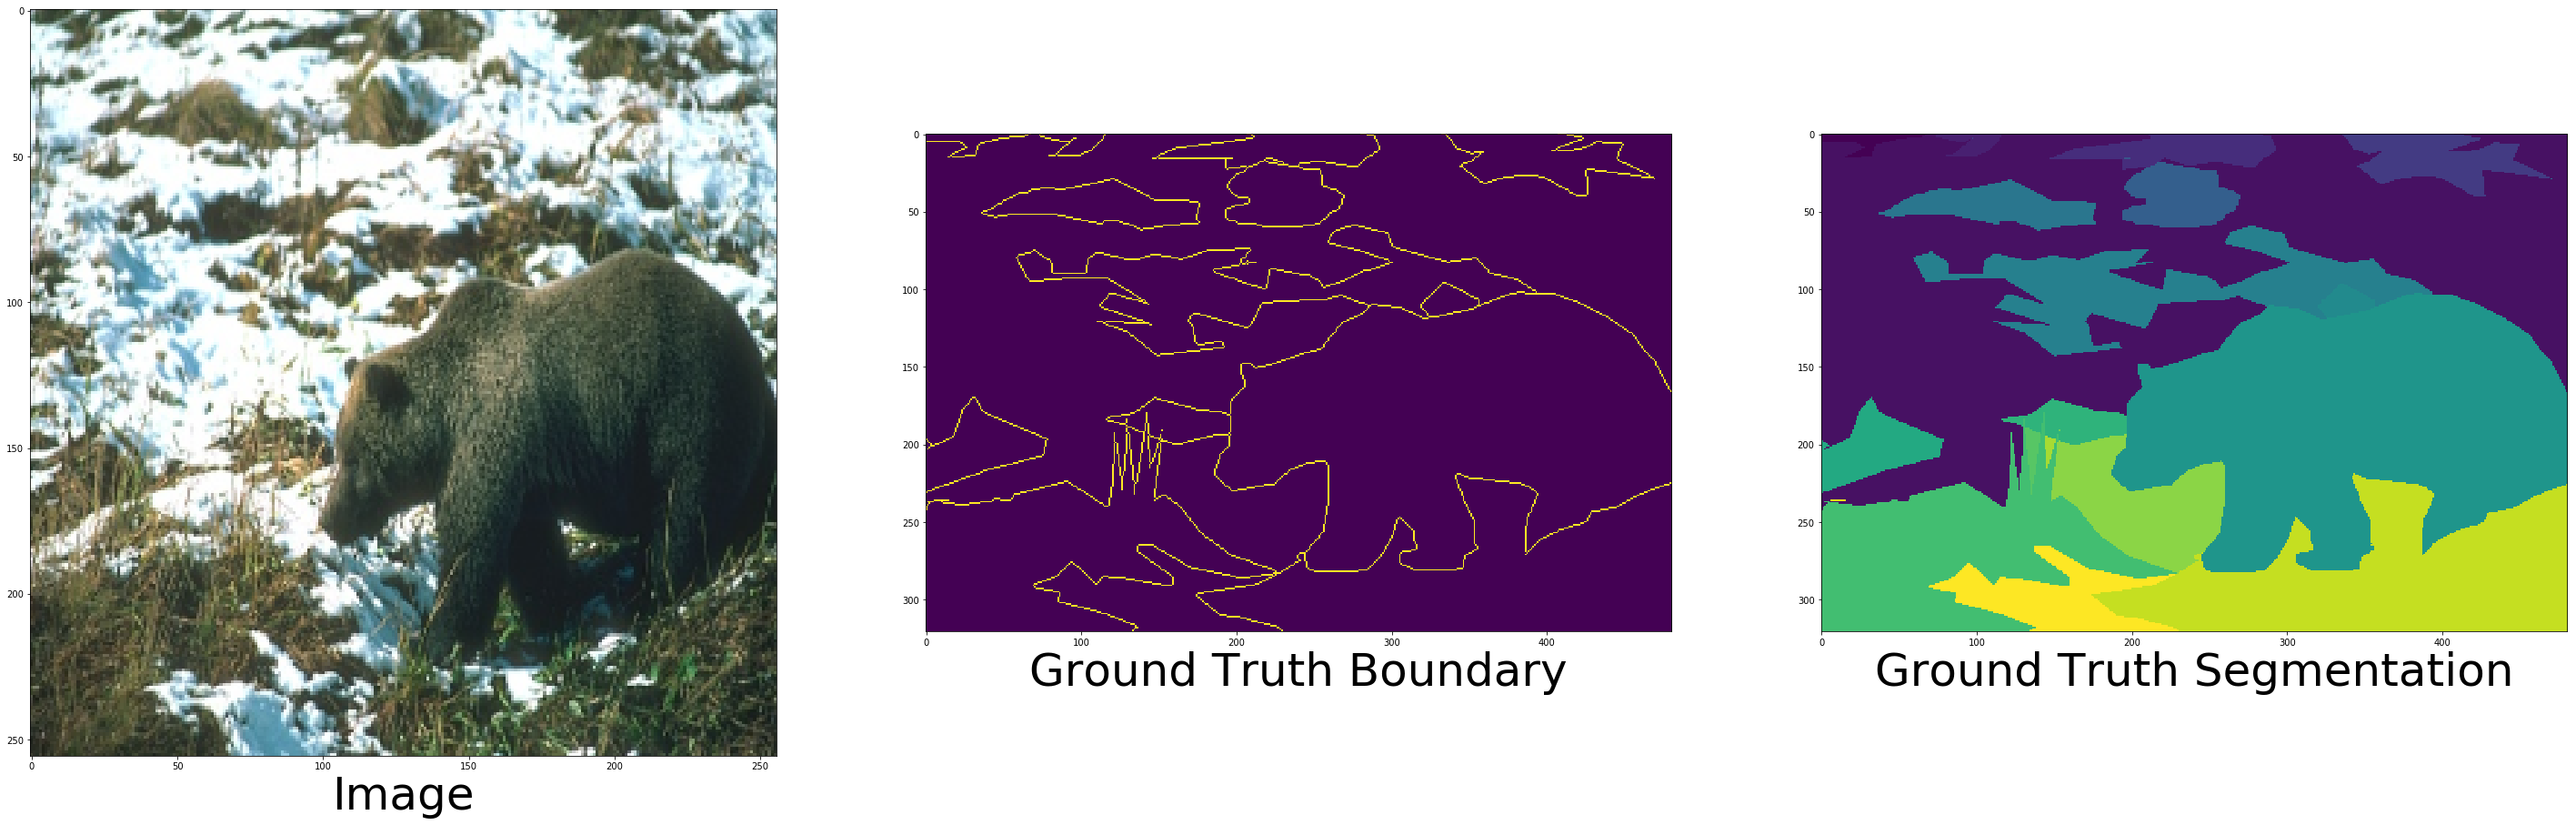

In [16]:
for i in range(3):
    img_path = train_images[i]
    seg_path = ground_truth_train_images[i]
    im.show_images(img_path, seg_path)

## Segmentation

### Output

**Output images are saved to 'output/SUB_DIR', where:**
1. 'output' directory is at the same directory where project runs.
2. SUB_DIR is either 'k-means' or 'normalized-cut', depending on the applied algorithm.

### Evaluation

- Since our clustering techniques assign arbitrary labels to each cluster, it never makes sense to try to compare our labeling to the provided ground truth labels; as label assignment will be inconsistent.
- Normally, precision and recall can be of great help, only when label assignment is consistent, as in the classification problem.
- In cluster analysis, the common approach is to apply the *F1-Measure* to the precision and recall of **pairs**, often referred to as *Pair Counting F-Measure*.
- Same applies to *Conditional Entropy*.
- In particular, any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar that members of different classes according to some similarity metric.
- One solution here is to use **substitute measures that can be seen exactly as *F1-Measure* and *Conditional Entropy***, but in the clustering frame, that is to preserve the previously mentioned characterstics.
- For *F-Measure*, we use ***Adjusted Rand Index*** and ***Adjusted Mutual Information***.
- For *Conditional Entropy*, we use ***Homogeneity*** and ***Completeness***.
- Resources: [\[1\]](https://stackoverflow.com/questions/12725263/computing-f-measure-for-clustering), 
[\[2\]](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), 
[\[3\]](https://stackoverflow.com/questions/11683785/how-can-i-match-up-cluster-labels-to-my-ground-truth-labels-in-matlab), 
[\[4\]](https://stats.stackexchange.com/questions/260229/comparing-a-clustering-algorithm-partition-to-a-ground-truth-one), 
[\[5\]](https://stats.stackexchange.com/questions/56883/using-f1-score-to-measure-cluster-validity/56886), 
[\[6\]](http://www.ims.uni-stuttgart.de/institut/mitarbeiter/schulte/theses/phd/algorithm.pdf)

In [4]:
###########################################################################################
# Given predicted labels and different ground truth labels, this function returns various #
# clustering evaluation measures over all the specified ground truth segmentations.       #
# @Params:                                                                                #
#   pred_labels: ndarray of predicted labels (clustering)                                 #
#   gt_segmentations: ndarray of different ground truth segmentations                     #
# @Returns:                                                                               #
#   adjusted_rand_scores                                                                  #
#   adjusted_mutual_info_scores                                                           #
#   homogeneity_scores                                                                    #
#   completeness_scores                                                                   #
###########################################################################################

def evaluate(pred_labels, gt_segmentations):
    
    adjusted_rand_scores = []
    adjusted_mutual_info_scores = []
    homogeneity_scores = []
    completeness_scores = []

    for seg in range(gt_segmentations.size):  
        gt_labels = gt_segmentations[0][seg]['Segmentation'][0][0]
        
        adjusted_rand_scores.append(adjusted_rand_score(gt_labels.ravel(), pred_labels.ravel()))
        adjusted_mutual_info_scores.append(adjusted_mutual_info_score(gt_labels.ravel(), pred_labels.ravel()))
        
        homogeneity_scores.append(homogeneity_score(gt_labels.ravel(), pred_labels.ravel()))
        completeness_scores.append(completeness_score(gt_labels.ravel(), pred_labels.ravel()))
        
    return adjusted_rand_scores, adjusted_mutual_info_scores, homogeneity_scores, completeness_scores

### Report

In [5]:
##############################################################################################
# Given various evaluation measures over different ground truth segmentations, this function #
# computes the average of each measure over the specified segmentations creating a complete  #
# report on the applied segmentation algorithm.                                              #
# @Params:                                                                                   #
#   adjusted_rand_scores                                                                     #
#   adjusted_mutual_info_scores                                                              #
#   homogeneity_scores                                                                       #
#   completeness_scores                                                                      #
# @Returns:                                                                                  #
#   a formatted dataframe encapsulating the generated report                                 #
##############################################################################################

def report(adjusted_rand_scores, adjusted_mutual_info_scores,
           homogeneity_scores, completeness_scores):
    adjusted_rand_scores.append(np.mean(adjusted_rand_scores))
    adjusted_mutual_info_scores.append(np.mean(adjusted_mutual_info_scores))
    homogeneity_scores.append(np.mean(homogeneity_scores))
    completeness_scores.append(np.mean(completeness_scores))

    measures = {'Adjusted Rand Index': adjusted_rand_scores,
                'Adjusted Mutual Information': adjusted_mutual_info_scores,
                'Homogeneity': homogeneity_scores,
                'Completeness': completeness_scores}
    
    index = ['Seg ' + str(i+1) for i in range(gt_segmentations.size)]
    index.append('Average')

    return pd.DataFrame(measures , index=index)

### K-means

**We pick a random test sample and perform only one iteration to speed up the process...**

Segmenting 326025.jpg, compared to 5 ground truth segmentations...

Segmenting with k=3...


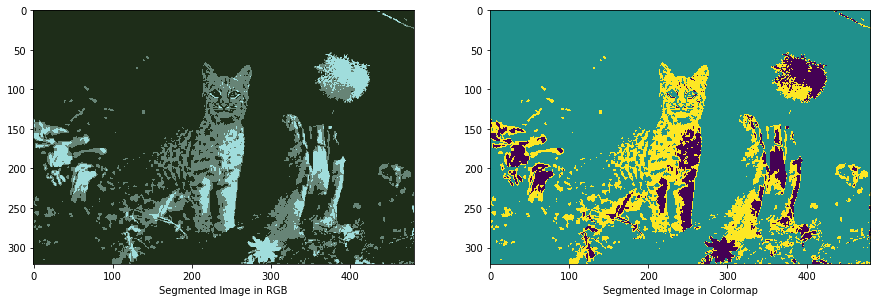

,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.321525,0.136771,0.136804,0.298433
Seg 2,0.221503,0.128832,0.128861,0.247846
Seg 3,0.314582,0.133759,0.133846,0.325524
Seg 4,0.380425,0.153297,0.153328,0.292031
Seg 5,0.372715,0.141429,0.141457,0.225554
Average,0.322150,0.138818,0.138859,0.277878



Segmenting with k=5...


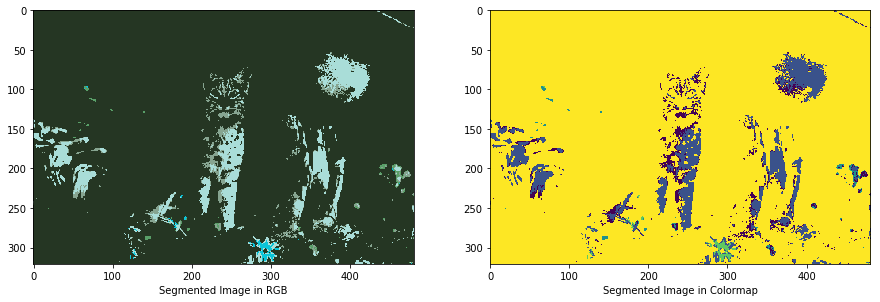

,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.147148,0.069037,0.069108,0.244152
Seg 2,0.087512,0.054253,0.054302,0.169148
Seg 3,0.141677,0.069437,0.069611,0.274182
Seg 4,0.185657,0.077366,0.077430,0.238837
Seg 5,0.183678,0.065010,0.065072,0.168038
Average,0.149134,0.067021,0.067104,0.218871



Segmenting with k=7...


/home/abeer/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/abeer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


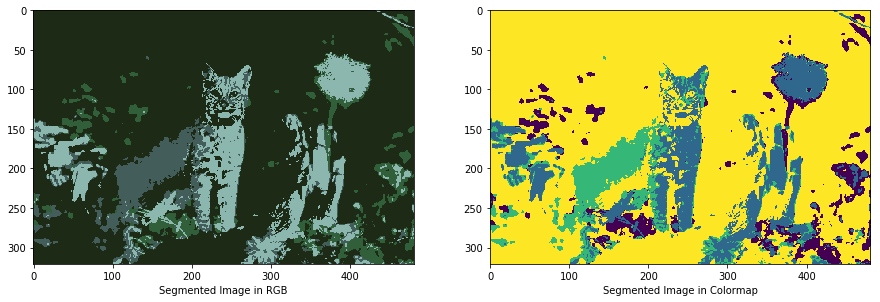

,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.340430,0.183205,0.183251,0.287648
Seg 2,0.267219,0.174733,0.174774,0.241882
Seg 3,0.354901,0.190511,0.190634,0.333612
Seg 4,0.396075,0.199406,0.199450,0.273343
Seg 5,0.372447,0.191548,0.191587,0.219816
Average,0.346214,0.187881,0.187939,0.271260



Segmenting with k=9...


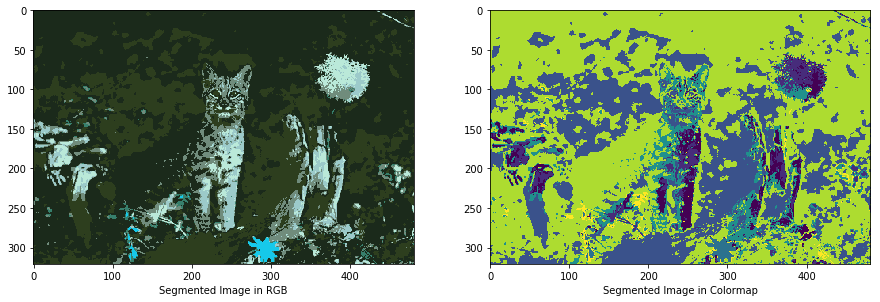

,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.179277,0.134236,0.134336,0.156791
Seg 2,0.113104,0.106934,0.107012,0.110123
Seg 3,0.181108,0.143180,0.143433,0.186640
Seg 4,0.213427,0.146090,0.146182,0.148964
Seg 5,0.195259,0.119363,0.140001,0.119436
Average,0.176435,0.129961,0.134193,0.144391



Segmenting with k=11...


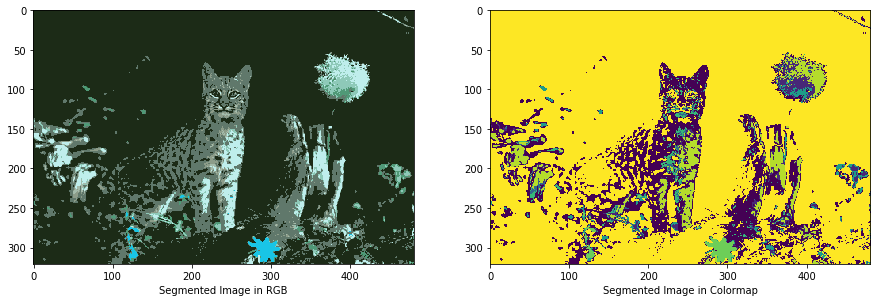

,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.356317,0.168738,0.168864,0.278402
Seg 2,0.252464,0.157969,0.158058,0.229756
Seg 3,0.355072,0.174437,0.174732,0.321172
Seg 4,0.417386,0.186105,0.186217,0.268048
Seg 5,0.408555,0.178403,0.178509,0.215117
Average,0.357959,0.173131,0.173276,0.262499


In [7]:
i = random.choice(range(len(test_images)))

gt_segmentations = loadmat(ground_truth_test_images[i]).get('groundTruth')

print ('Segmenting {}, compared to {} ground truth segmentations...'
      .format(os.path.basename(test_images[i]), gt_segmentations.size))

for k in [3, 5, 7, 9, 11]:
    print()
    print('Segmenting with k={}...'.format(k))
    pred_labels, segmented_img = kmeans.segment(test_images[i], k, iterations=1)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    axes.flat[0].imshow(segmented_img)
    axes.flat[0].set_xlabel("Segmented Image in RGB")
    axes.flat[1].imshow(pred_labels)
    axes.flat[1].set_xlabel("Segmented Image in Colormap")
    plt.show()
    display(report(*evaluate(pred_labels, gt_segmentations)))

---
**Comments:**
- **As k increases, results do not necessarily get better; that is due to the fact that label assignment is inconsistent, and the used measures try to achieve the BEST mapping possible.**
- **Also, ground truth segmentations consider complete object to be one segment having the same label, unlike our algorithm, where different pixels of the same object may be assigned to different labels (clusters); depending on their color shadows (RGB values). This can very much lower the matching probability**

### Normalized Cut

#### RBF Kernel

Segmenting 250087.jpg, compared to 5 ground truth segmentations...


C:\Users\lenovo pc\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\lenovo pc\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


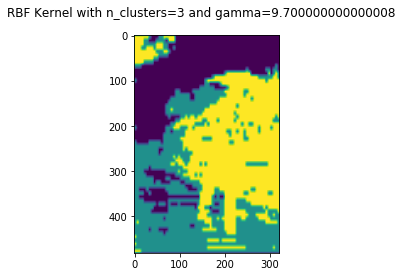

,Adjusted Mutual Information,Adjusted Rand Index,Completeness,Homogeneity
Seg 1,0.245579,0.356722,0.323589,0.595046
Seg 2,0.230550,0.389432,0.292907,0.654967
Seg 3,0.236395,0.357363,0.309219,0.603869
Seg 4,0.241353,0.353671,0.317725,0.593405
Seg 5,0.231281,0.349510,0.304187,0.599022
Average,0.237032,0.361339,0.309525,0.609262


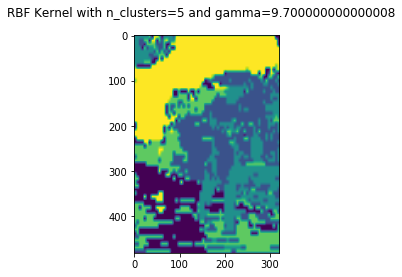

,Adjusted Mutual Information,Adjusted Rand Index,Completeness,Homogeneity
Seg 1,0.190371,0.365720,0.287346,0.787480
Seg 2,0.164858,0.340808,0.243994,0.813104
Seg 3,0.181910,0.361057,0.272677,0.793603
Seg 4,0.185779,0.366514,0.280960,0.782027
Seg 5,0.179526,0.353422,0.269995,0.792380
Average,0.180489,0.357504,0.270995,0.793719


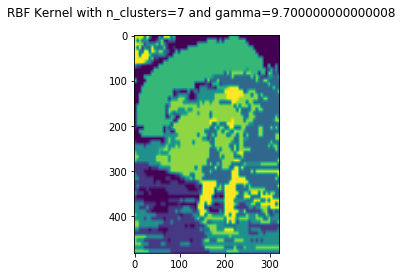

,Adjusted Mutual Information,Adjusted Rand Index,Completeness,Homogeneity
Seg 1,0.157794,0.213997,0.263190,0.837551
Seg 2,0.140171,0.211359,0.225398,0.872218
Seg 3,0.153425,0.216605,0.251648,0.850464
Seg 4,0.154586,0.210887,0.257913,0.833601
Seg 5,0.152497,0.212009,0.250197,0.852648
Average,0.151695,0.212972,0.249669,0.849297


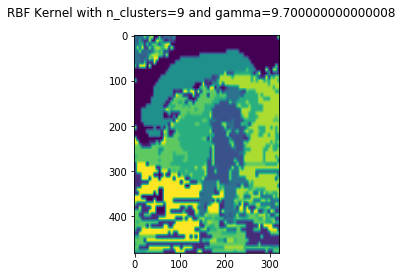

,Adjusted Mutual Information,Adjusted Rand Index,Completeness,Homogeneity
Seg 1,0.163162,0.188457,0.270107,0.902137
Seg 2,0.143812,0.181058,0.230828,0.937471
Seg 3,0.157515,0.188669,0.257499,0.913340
Seg 4,0.159197,0.186957,0.264233,0.896325
Seg 5,0.156183,0.184292,0.255662,0.914423
Average,0.155974,0.185887,0.255666,0.912739


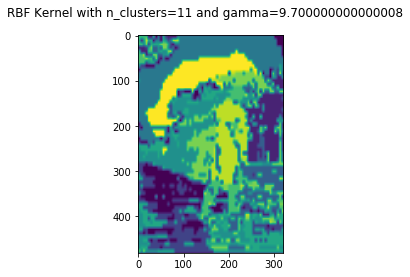

,Adjusted Mutual Information,Adjusted Rand Index,Completeness,Homogeneity
Seg 1,0.149753,0.171700,0.262805,0.932303
Seg 2,0.128265,0.155815,0.220680,0.951961
Seg 3,0.143954,0.170153,0.249805,0.941122
Seg 4,0.146844,0.170519,0.257835,0.928987
Seg 5,0.142009,0.164640,0.247368,0.939748
Average,0.142165,0.166565,0.247699,0.938824


In [31]:
n_clusters=[3, 5, 7, 9, 11]

#Generate different gammas from the permitted range
gammas = np.arange(1, 10.1, .1)
gamma = random.choice(gammas)
i = random.choice(range(len(test_images)))

gt_segmentations = loadmat(ground_truth_test_images[i]).get('groundTruth')

print ('Segmenting {}, compared to {} ground truth segmentations...'
      .format(os.path.basename(test_images[i]), gt_segmentations.size))

for cluster in n_clusters:
    pred_labels_rbf = nc.segment(test_images[i], n_clusters=cluster, gamma=gamma)
    plt.imshow(pred_labels_rbf)
    plt.suptitle("RBF Kernel with n_clusters={} and gamma={}".format(cluster, gamma))
    plt.show()
    display(report(*evaluate(pred_labels_rbf, gt_segmentations)))

#### K-NN Similarity Graph

C:\Users\lenovo pc\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\lenovo pc\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\lenovo pc\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


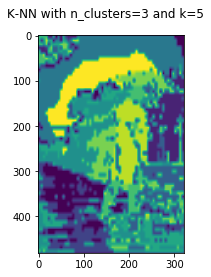

C:\Users\lenovo pc\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:605: RuntimeWarning: invalid value encountered in log
  log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())


,Adjusted Mutual Information,Adjusted Rand Index,Completeness,Homogeneity
Seg 1,NaN,0.158068,NaN,NaN
Seg 2,NaN,0.207177,NaN,NaN
Seg 3,NaN,0.164484,NaN,NaN
Seg 4,NaN,0.150017,NaN,NaN
Seg 5,NaN,0.163600,NaN,NaN
Average,NaN,0.168669,NaN,NaN


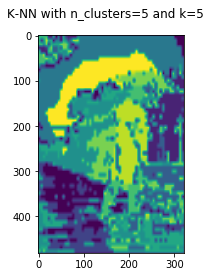

,Adjusted Mutual Information,Adjusted Rand Index,Completeness,Homogeneity
Seg 1,0.214375,0.243010,0.297736,0.582531
Seg 2,0.208178,0.293350,0.274203,0.652367
Seg 3,0.208370,0.247913,0.285961,0.594175
Seg 4,0.212051,0.240357,0.293534,0.583296
Seg 5,0.203157,0.240094,0.280801,0.588344
Average,0.209226,0.252945,0.286447,0.600143


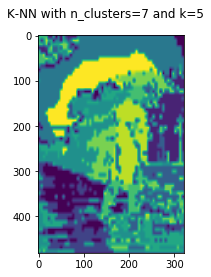

,Adjusted Mutual Information,Adjusted Rand Index,Completeness,Homogeneity
Seg 1,0.167814,0.165649,0.265052,0.730650
Seg 2,0.158916,0.200304,0.236493,0.792736
Seg 3,0.163538,0.171043,0.254009,0.743615
Seg 4,0.167482,0.165354,0.262402,0.734664
Seg 5,0.159709,0.164935,0.250032,0.738104
Average,0.163492,0.173457,0.253598,0.747954


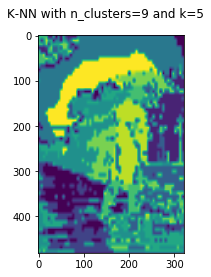

,Adjusted Mutual Information,Adjusted Rand Index,Completeness,Homogeneity
Seg 1,0.139805,0.101743,0.246052,0.794221
Seg 2,0.122664,0.101330,0.208392,0.817953
Seg 3,0.135274,0.103818,0.234242,0.802972
Seg 4,0.136274,0.097299,0.240432,0.788225
Seg 5,0.133595,0.101264,0.232128,0.802394
Average,0.133522,0.101091,0.232249,0.801153


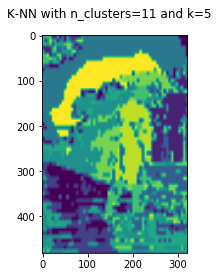

,Adjusted Mutual Information,Adjusted Rand Index,Completeness,Homogeneity
Seg 1,0.128278,0.071357,0.240038,0.861416
Seg 2,0.114823,0.076965,0.204748,0.893479
Seg 3,0.126018,0.075610,0.229913,0.876228
Seg 4,0.126399,0.067304,0.235790,0.859413
Seg 5,0.124255,0.072879,0.227692,0.875034
Average,0.123955,0.072823,0.227636,0.873114


In [32]:
k=5
for cluster in n_clusters:
    pred_labels_knn = nc.segment(test_images[i], n_clusters=cluster, k=k, is_rbf=False)
    plt.imshow(pred_labels_rbf)
    plt.suptitle("K-NN with n_clusters={} and k={}".format(cluster, k))
    plt.show()
    display(report(*evaluate(pred_labels_knn, gt_segmentations)))

---
**Comments:**
- **Adjusted Mutual Information and Adjusted Rand Index (substitute F-Measure) are not very promising, one of the reasons is the fact that sample images had to be resized before the segmentation.**
- **On the other hand, Homogeneity (substitute Conditional Entropy) shows good results; due to the fact that a whole object is often given the same label. In other words, each cluster contains only members of a single class as in the case of ground truth segmentation.**

## Big Picture

**Here, we choose 5 test samples. For each we display:**
1. ground truth segmentation.
2. k-means segmenttaion.
3. normalized cut segmentation.
4. k-means segmentation evaluation.
5. normalized cut segmentation evaluation.

Segmenting 108004.jpg...


/home/abeer/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/abeer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/abeer/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/abeer/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


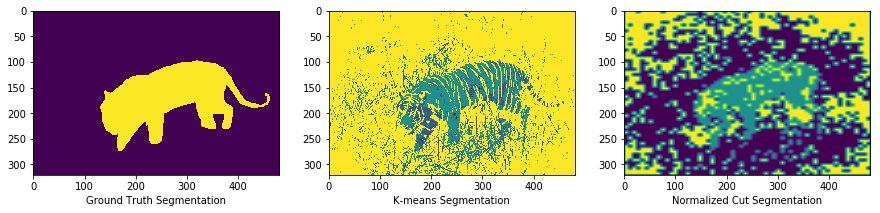

,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.425988,0.188760,0.266692,0.188772
Seg 2,0.427390,0.189291,0.270129,0.189328
Seg 3,0.435860,0.195361,0.271446,0.195383
Seg 4,0.444160,0.188801,0.189523,0.228815
Seg 5,0.382909,0.192673,0.204638,0.192769
Average,0.423261,0.190977,0.240485,0.199013


,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.052300,0.026855,0.920856,0.055230
Seg 2,0.050757,0.026697,0.923868,0.054866
Seg 3,0.050900,0.026794,0.914463,0.055773
Seg 4,0.052801,0.035325,0.852787,0.087240
Seg 5,0.053651,0.028057,0.838329,0.066914
Average,0.052082,0.028746,0.890061,0.064005


Segmenting 64061.jpg...


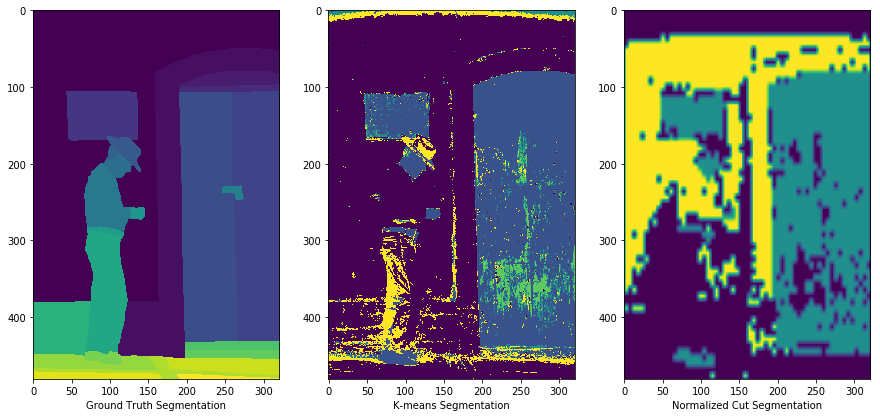

,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.323151,0.267426,0.267532,0.548075
Seg 2,0.357122,0.293516,0.293554,0.466964
Seg 3,0.373644,0.311251,0.311314,0.536677
Seg 4,0.378000,0.311589,0.311661,0.516358
Seg 5,0.306914,0.232359,0.232556,0.508303
Average,0.347766,0.283228,0.283323,0.515275


,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.182409,0.178076,0.553716,0.270234
Seg 2,0.226596,0.144397,0.570275,0.216107
Seg 3,0.237591,0.170599,0.602400,0.247393
Seg 4,0.228042,0.158990,0.591442,0.233437
Seg 5,0.190831,0.191286,0.556296,0.289662
Average,0.213094,0.168670,0.574826,0.251366


Segmenting 226022.jpg...


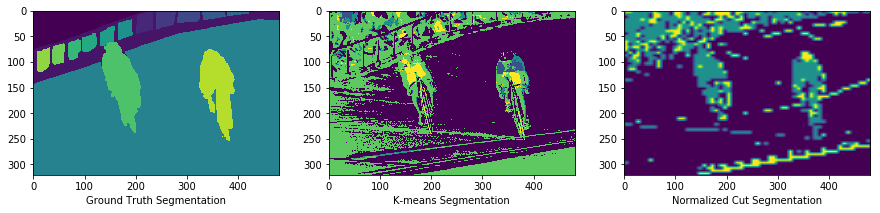

,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.233521,0.113139,0.113299,0.161042
Seg 2,0.230035,0.142969,0.146855,0.143085
Seg 3,0.226070,0.120813,0.121081,0.156059
Seg 4,0.225098,0.117229,0.117513,0.158344
Seg 5,0.117783,0.106946,0.107072,0.299185
Average,0.206501,0.120219,0.121164,0.183543


,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.583698,0.172259,0.778427,0.237115
Seg 2,0.542353,0.114494,0.767750,0.160306
Seg 3,0.596012,0.178051,0.858991,0.237263
Seg 4,0.589560,0.185234,0.855932,0.247164
Seg 5,0.149442,0.168298,0.494048,0.295843
Average,0.492213,0.163667,0.751030,0.235538


Segmenting 243095.jpg...


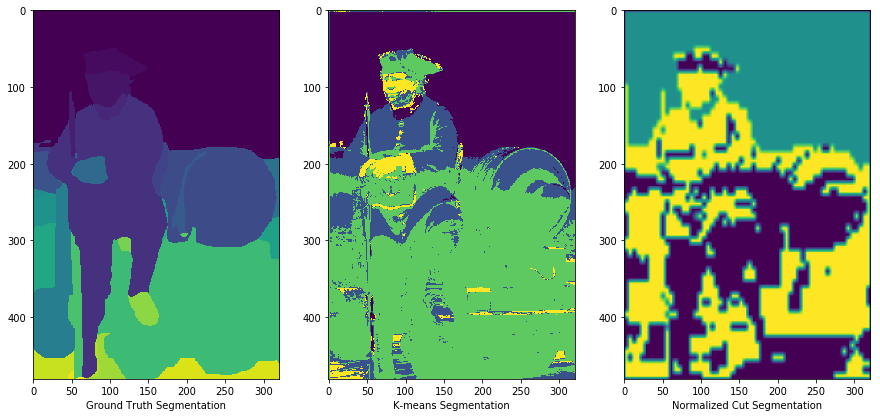

,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.408011,0.311045,0.311157,0.588141
Seg 2,0.347191,0.275176,0.275286,0.643198
Seg 3,0.382361,0.268855,0.268940,0.565596
Seg 4,0.291373,0.226945,0.227093,0.611560
Seg 5,0.295092,0.227394,0.227628,0.664597
Average,0.344806,0.261883,0.262021,0.614618


,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.436008,0.221479,0.598602,0.300714
Seg 2,0.502663,0.274259,0.592222,0.367755
Seg 3,0.440472,0.237830,0.581908,0.325252
Seg 4,0.484678,0.282064,0.546771,0.391342
Seg 5,0.493521,0.313338,0.553286,0.429336
Average,0.471468,0.265794,0.574558,0.362880


Segmenting 368037.jpg...


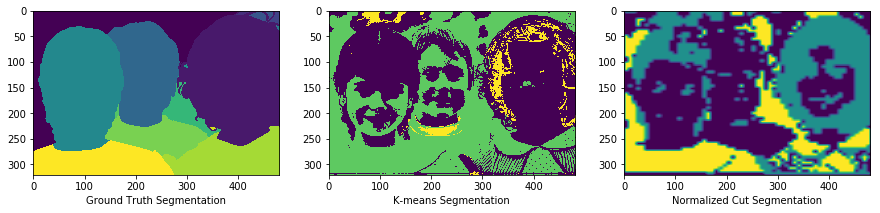

,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.127960,0.141363,0.141406,0.324151
Seg 2,0.087832,0.140541,0.140576,0.385719
Seg 3,0.067486,0.130777,0.130864,0.425663
Seg 4,0.049305,0.103677,0.103746,0.275487
Seg 5,0.075102,0.131991,0.132080,0.422660
Seg 6,0.079875,0.139346,0.139413,0.426281
Average,0.081260,0.131282,0.131347,0.376660


,Adjusted Rand Index,Adjusted Mutual Information,Homogeneity,Completeness
Seg 1,0.162108,0.133016,0.537926,0.219731
Seg 2,0.186928,0.169959,0.553041,0.270398
Seg 3,0.171385,0.197888,0.545950,0.316436
Seg 4,0.149041,0.165492,0.558655,0.264338
Seg 5,0.169457,0.195219,0.547457,0.312172
Seg 6,0.187808,0.193241,0.558727,0.304426
Average,0.171121,0.175803,0.550293,0.281250


In [8]:
indices = [18, 178, 98, 109, 154]

for i in indices:
    gt_segmentations = loadmat(ground_truth_test_images[i]).get('groundTruth')
    gt_seg = gt_segmentations[0][0]['Segmentation'][0][0]
    
    print ('Segmenting {}...'.format(os.path.basename(test_images[i]), gt_segmentations.size))

    kmeans_pred_labels, _ = kmeans.segment(test_images[i], 5, iterations=1)
    norm_cut_pred_labels = nc.segment(test_images[i], k=5)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
    
    axes.flat[0].imshow(gt_seg)
    axes.flat[0].set_xlabel("Ground Truth Segmentation")
    axes.flat[1].imshow(kmeans_pred_labels)
    axes.flat[1].set_xlabel("K-means Segmentation")
    axes.flat[2].imshow(norm_cut_pred_labels)
    axes.flat[2].set_xlabel("Normalized Cut Segmentation")
    plt.show()
    
    display(report(*evaluate(kmeans_pred_labels, gt_segmentations)))
    display(report(*evaluate(norm_cut_pred_labels, gt_segmentations)))

---
**Comments:**
- **Results vary between both algorithms.**
- **Normalized Cut gives higher Homogeneity in most of the cases.**